# Tweet # Counts

Time series, counts by week.


#### Libraries + DB

In [1]:
%run utilities.py
%run ../../src/secret_key.py

import psycopg2 as pg
import pandas.io.sql as psql

from matplotlib import pyplot as plt
%matplotlib inline

ERROR:root:File `'../../src/secret_key.py'` not found.


In [2]:
## get connected to the database
#connection = pg.connect("dbname=mydatabase user=postgres")
#dataframe = psql.frame_query("SELECT id, price FROM stock_price", connection)
#conn = psycopg2.connect("dbname='template1' user='dbuser' host='localhost' password='dbpass'")

conn_str = "dbname='immigration' user='rlrson' password={}".format(pw)
conn = pg.connect(conn_str)

#### Time Periods

Caglar has broken them down into before/after the 'epoch' date. Lets pull them in.

In [3]:
time_periods = pd.read_sql("SELECT * FROM timeinterval;", con=conn)
time_periods

,id,startinterval,endinterval
0,1,2016-12-27 10:00:00+00:00,2017-01-27 10:00:00+00:00
1,2,2017-01-28 10:00:00+00:00,2017-02-27 10:00:00+00:00
2,3,2017-01-21 10:00:00+00:00,2017-01-27 10:00:00+00:00
3,4,2017-01-28 10:00:00+00:00,2017-02-03 10:00:00+00:00
4,5,2017-01-26 10:00:00+00:00,2017-01-27 10:00:00+00:00
5,6,2017-01-28 10:00:00+00:00,2017-01-29 10:00:00+00:00


In [4]:
time_periods.dtypes

id                             int64
startinterval    datetime64[ns, UTC]
endinterval      datetime64[ns, UTC]
dtype: object

In [5]:
# set variables so we can specify a beginning/end for our SQL queries
start = time_periods.iloc[0]['startinterval'].tz_convert(None)
end = time_periods.iloc[1]['endinterval'].tz_convert(None)

#### County IDs

From Caglar:
> It looks like I parsed the internal id as cntyid. Internal id comes from the order of the counties in the shape file (dbf). You can create a new field to fix the issue.

In [6]:
import geopandas as gpd

us_counties_f = name_file_path('caglar/countyID/us_cnty_wgs84latlon.shp', external_data_dir)

In [7]:
us_counties = gpd.read_file(us_counties_f)
us_counties.head()

,NEWSTCNTY,geometry,id
0,01001,POLYGON ((-86.41314149216106 32.70725681089197...,1001
1,01003,POLYGON ((-87.61590072233568 31.24428493497927...,1003
2,01005,POLYGON ((-85.05610018188545 32.06289786163329...,1005
3,01007,POLYGON ((-87.02685453058996 33.24634461782348...,1007
4,01009,"POLYGON ((-86.3035171854426 34.09900150822232,...",1009


In [8]:
us_counties['id'] = us_counties.index
#us_counties['id'] = us_counties.id.map(lambda x: str(x))
us_counties.set_index('id', inplace=True)

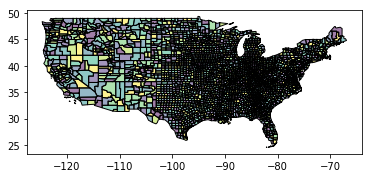

In [9]:
us_counties.plot()

In [10]:
def lookup_county(table_id, counties):
    """
    Simple Function to lookup a county's FIPS code. 
    """
    return counties.iloc[table_id]['NEWSTCNTY']

In [11]:
# test the lookup
lookup_county(183, us_counties)

'06053'

#### County/State Crosswalk 

Adding State name to counties. Download the file from the internet, and load it into a dataframe.

In [12]:
census_cols = ['abbrv', 'STATE', 'STATEFP', 'COUNTYFP', 'COUNTYNAME']
dtypes = {'STATE': 'str', 'STATEFP':'str'}
cnty_st_xwalk = pd.read_csv('https://www2.census.gov/geo/docs/reference/codes/files/national_county.txt',
                          names=census_cols,
                          dtype=dtypes)
cnty_st_xwalk.head()

,abbrv,STATE,STATEFP,COUNTYFP,COUNTYNAME
0,AL,01,001,Autauga County,H1
1,AL,01,003,Baldwin County,H1
2,AL,01,005,Barbour County,H1
3,AL,01,007,Bibb County,H1
4,AL,01,009,Blount County,H1


In [13]:
cnty_st_xwalk['FIPS'] = cnty_st_xwalk['STATE'] + cnty_st_xwalk['STATEFP']
cnty_st_xwalk.set_index('FIPS', inplace=True)

In [14]:
def lookup_state(FIPS, states):
    """
    Simple Function to lookup a county's State abbrv. 
    """
    return states.loc[FIPS]['abbrv']

In [15]:
# test the lookup
lookup_state('06053', cnty_st_xwalk)

'CA'

#### Tweets

We need a count of tweets from every county, for every week (8: 4-before/after). The `tweet` table has tweetid, tweet, date, userid, id, lon, lat, cntyid.

In [16]:
tweet_query = "SELECT date, userID, lon, lat, cntyID FROM tweet LIMIT 75000;"

tweet_df = pd.read_sql(tweet_query, con=conn)
tweet_df.head()

,date,userid,lon,lat,cntyid
0,Sun Dec 25 21:45:36 CST 2016,344933751,-84.174260,34.535420,398
1,Sun Dec 25 21:45:38 CST 2016,2754020013,-82.687256,27.801315,341
2,Sun Dec 25 21:45:41 CST 2016,185912082,-94.596870,38.941310,1495
3,Sun Dec 25 21:45:45 CST 2016,342852970,-96.883354,32.816670,2544
4,Sun Dec 25 21:45:47 CST 2016,1338600822,-74.070000,40.960000,1740


In [17]:
tweet_df.dtypes

date       object
userid      int64
lon       float64
lat       float64
cntyid      int64
dtype: object

In [18]:
##################################################
#test the county modifier

tweet_df['cnty'] = tweet_df['cntyid'].map(lambda x: lookup_county(x, us_counties))
tweet_df['st'] = tweet_df['cnty'].map(lambda x: lookup_state(x, cnty_st_xwalk))

In [19]:
tweet_df.head(1)

,date,userid,lon,lat,cntyid,cnty,st
0,Sun Dec 25 21:45:36 CST 2016,344933751,-84.17426,34.53542,398,13085,GA


#### Week Categorization

We need to create a mapping that will return the week number for us. We'll start at the epoch and work our way backwards week by week. After a month we'll do 'after' the epoch.

In [20]:
# actually add the epoch too
epoch_start = pd.to_datetime('2017-01-27 10:00:00+00:00', utc=True).tz_convert(None)
epoch_end = pd.to_datetime('2017-01-28 10:00:00+00:00', utc=True).tz_convert(None)

delta_week = pd.Timedelta('7 days')

In [21]:
# epoch_start - (delta_week * 4) >> Timestamp('2016-12-30 10:00:00')
# start >> Timestamp('2016-12-27 10:00:00+0000', tz='UTC')

In [34]:
# set the variables
four_before = epoch_start - (delta_week * 4)
three_before = epoch_start - (delta_week * 3)
two_before = epoch_start - (delta_week * 2)
one_before = epoch_start - (delta_week * 1)

four_after = epoch_end + (delta_week * 4)
three_after = epoch_end + (delta_week * 3)
two_after = epoch_end + (delta_week * 2)
one_after = epoch_end + (delta_week * 1)

def get_week_number(week):
    try:
        week = pd.to_datetime(week, infer_datetime_format=True)
    
        # catch, before/after?
        if (week < start) or (week > end):
            return None

        if (week < four_before):
            return -5
        elif (week < three_before):
            return -4
        elif (week < two_before):
            return -3
        elif (week < one_before):
            return -2
        elif (week < epoch_start):
            return -1
        elif (week < epoch_end):
            return 0
        elif (week < one_after):
            return 1
        elif (week < two_after):
            return 2
        elif (week < three_after):
            return 3
        elif (week < four_after):
            return 4
        else:
            return 5
    except Exception as e:
        print (e, week)
        return None

In [23]:
tweet_df['week'] = tweet_df.date.map(lambda x: get_week_number(pd.to_datetime(x, infer_datetime_format=True)))

In [24]:
tweet_df.tail(10)

,date,userid,lon,lat,cntyid,cnty,st,week
74990,Wed Dec 28 23:15:48 CST 2016,758140914753638400,-97.74063,30.274000,2714,48453,TX,-5.0
74991,Wed Dec 28 23:15:56 CST 2016,3267464186,-95.83020,29.740200,2566,48157,TX,-5.0
74992,Wed Dec 28 23:16:00 CST 2016,576929307,-75.20717,38.735195,288,10005,DE,-5.0
74993,Wed Dec 28 23:16:00 CST 2016,1479152634,-75.24621,39.969810,2259,42101,PA,-5.0
74994,Wed Dec 28 23:16:01 CST 2016,583252309,-97.74063,30.274000,2714,48453,TX,-5.0
74995,Wed Dec 28 23:16:08 CST 2016,850286970,-95.83020,29.740200,2566,48157,TX,-5.0
74996,Wed Dec 28 23:16:11 CST 2016,485092101,-75.20717,38.735195,288,10005,DE,-5.0
74997,Wed Dec 28 23:16:12 CST 2016,759454825,-75.24621,39.969810,2259,42101,PA,-5.0
74998,Wed Dec 28 23:16:13 CST 2016,3299370200,-97.74063,30.274000,2714,48453,TX,-5.0
74999,Wed Dec 28 23:16:20 CST 2016,799627519641034752,-95.83020,29.740200,2566,48157,TX,-5.0


In [25]:
tweet_df[(tweet_df.week < -5) & (tweet_df.week < 5)].head()

,date,userid,lon,lat,cntyid,cnty,st,week


In [26]:
# IT WORKS: WE WANT THIS
tweet_df[['st', 'week', 'cnty']].groupby(['st', 'week']).count()

cnty
st week       
CA -5.0  13586
CO -5.0   1586
CT -4.0      1
DC -5.0   1974
DE -5.0   3660
FL -5.0  12716
   -4.0      1
GA -5.0    432
IL -4.0      1
LA -5.0   1466
MA -5.0   6919
MO -4.0      1
NC -5.0   3467
NJ -5.0   1708
   -4.0      2
NY -5.0   7278
   -4.0      1
OH -5.0   1348
OR -5.0     32
PA -5.0    192
TN -5.0    877
TX -5.0   9236
VA -5.0   2807

#### Parallelize

This is going to take forever unless we do.

In [27]:
from multiprocessing import Pool  # faster

def parallelize_series(series, func):
    pool = Pool(6)

    df = pool.map(func, series)

    pool.close()
    pool.join()
    return df

In [54]:
#tweet_df['cnty'] = tweet_df['cntyid'].map(lambda x: lookup_county(str(x), us_counties))
#tweet_df['st'] = tweet_df['cnty'].map(lambda x: lookup_state(x, cnty_st_xwalk))
#tweet_df['week'] = tweet_df.date.map(lambda x: get_week_number(pd.to_datetime(x, infer_datetime_format=True)))


# ... with a little black magic
def format_cnty(x): 
    return lookup_county(x, us_counties)
def format_st(x): 
    return lookup_state(x, cnty_st_xwalk)
def format_week(x): 
    return get_week_number(x)

def group_tweets(tweets):
    # Add a county variable from Caglar's .dbf lookup
    tweets['cnty'] = parallelize_series(tweets.cntyid, format_cnty)

    # Get the state from the Census XWalk
    tweets['st'] = parallelize_series(tweets.cnty, format_st)

    # Assign a week number
    tweets['week'] = parallelize_series(tweets.date, format_week)
    
    # groupby our desired attributes
    grouped = tweets[['st', 'week', 'cnty']].groupby(['st', 'week']).count()
    
    return grouped

In [55]:
t = group_tweets(tweet_df.iloc[-100:])

/home/rlrson/anaconda3/envs/gdal/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/rlrson/anaconda3/envs/gdal/lib/python3.5/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/rlrson/anaconda3/envs/gdal/lib/python3.5/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [58]:
%timeit -n 1 t = group_tweets(tweet_df)

cnty
st week       
CA -5.0  13586
CO -5.0   1586
CT -4.0      1
DC -5.0   1974
DE -5.0   3660
FL -5.0  12716
   -4.0      1
GA -5.0    432
IL -4.0      1
LA -5.0   1466
MA -5.0   6919
MO -4.0      1
NC -5.0   3467
NJ -5.0   1708
   -4.0      2
NY -5.0   7278
   -4.0      1
OH -5.0   1348
OR -5.0     32
PA -5.0    192
TN -5.0    877
TX -5.0   9236
VA -5.0   2807

In [66]:
# df = pd.DataFrame()
# for chunk in pd.read_sql('select * from table_name', con=conn, chunksize=5000):
#    df = df.append(chunk)

# fake_query to test
counts = pd.DataFrame()
for chunk in pd.read_sql(tweet_query, con=conn, chunksize=5000):
    formatted = group_tweets(chunk)
    counts = counts.append(formatted)

#### State Counts!!!

In [70]:
# for real this time
full_query = "SELECT date, userID, lon, lat, cntyID FROM tweet;"

st_cnts = pd.DataFrame()
for chunk in pd.read_sql(full_query, con=conn, chunksize=50000):
    formatted = group_tweets(chunk)
    st_cnts = st_cnts.append(formatted)

In [71]:
# we have to sum all of the chunked counts
st_cnts.reset_index(inplace=True)

In [73]:
final = st_cnts.groupby(['st', 'week']).sum().reset_index()

In [74]:
final.head()

,st,week,cnty
0,AL,-2.0,204
1,AL,-1.0,2103
2,AL,1.0,49415
3,AL,2.0,23908
4,AL,4.0,6939


In [75]:
# finally
f = name_file_path('state-tweet-counts.csv', processed_web_dir)

final.rename(columns={'cnty': 'cnt'}, inplace=True)
final.to_csv(f, index=False)

In [76]:
conn.close()